<a href="https://colab.research.google.com/github/ashamril/optimization/blob/master/3b_SGCC_PSO_GA_Classification_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Electricity fraud prediction using supervised machine learning
# ANN, SVM, XGBoost and RF
# Undersampling using Particle Swarm Optimization (PSO)
# Parameters tuning for classifiers using Genetic Algorithm (GA)
# Author  : Ami
# Email   : ashamril@gmail.com

from datetime import datetime 
from google.colab import drive
from pytz import timezone  
from random import randint
from scipy import spatial
from scipy.stats import zscore
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import f1_score, average_precision_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from xgboost.sklearn import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import scipy.spatial
import seaborn as sns
import time
import warnings 

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
malaysia = timezone('Asia/Kuala_Lumpur')
mytime = datetime.now(malaysia)
first_start_time = datetime.now() 
start_time = datetime.now() 
#file_path = "/content/drive/My Drive/data/CSV/sgcc-no-missing-values-v4.csv"                           # Set1
#file_path = "/content/drive/My Drive/data/CSV/sgcc-no-missing-values_no-outliers-quantile.csv"         # Set2
#file_path = "/content/drive/My Drive/data/CSV/sgcc-no-missing-values_no-outliers-zscore.csv"           # Set3
#file_path = "/content/drive/My Drive/data/CSV/sgcc-no-missing-values_RobustScaler.csv"                 # Set4
#file_path = "/content/drive/My Drive/data/CSV/sgcc-no-missing-values_df_months.csv"                     # Set5
#file_path = "/content/drive/My Drive/data/CSV/sgcc-no-missing-values_QuantileTransformer_normal.csv"   # Set6
#file_path = "/content/drive/My Drive/data/CSV/sgcc-no-missing-values_QuantileTransformer_uniform.csv"  # Set7
#file_path = "/content/drive/My Drive/data/CSV/blood_transfusion.csv"                                   # Set8
file_path = "/content/drive/My Drive/data/CSV/sgcc-no-missing-values_PowerTransformer.csv"              # Set9
dataset_ori = pd.read_csv(file_path)
print('Time elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - start_time))

dataset_set = "Set9"
program_name = "PSO GA"

Time elapsed (hh:mm:ss.ms) 0:00:00.363204


In [ ]:
dataset = dataset_ori.iloc[:,1:]
dataset

,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,Total_Consumption,FLAG
0,0.440375,0.330824,0.061953,0.308703,0.277551,0.424533,1.057767,1.000471,1.206963,2.013552,1.261321,0.339349,0.421815,0.360503,0.398326,0.415234,0.414096,0.398141,0.392535,0.382551,0.386496,0.376098,0.364940,0.348950,0.458839,0.667682,0.536587,0.571912,0.455967,0.783170,1.121837,0.854400,0.786626,0.589241,0.706306,1
1,0.440375,0.330824,0.384403,0.403254,0.453112,0.467288,0.481438,0.411049,0.431765,0.608051,0.441683,0.427812,0.421815,0.360503,0.398326,0.415234,0.414096,0.398141,0.392535,0.382551,0.386496,0.376098,0.364940,0.348950,-1.791572,-1.806856,-1.786796,-1.780578,-1.797116,-1.766498,-1.745636,-1.768215,-1.824206,-1.785730,0.016757,1
2,0.440375,0.330824,0.384403,0.403254,0.453112,0.467288,0.481438,0.411049,0.431765,0.608051,0.441683,0.427812,0.421815,0.360503,0.398326,0.415234,0.414096,0.398141,0.392535,0.382551,0.386496,0.376098,0.364940,0.348950,0.676719,0.522279,0.513371,0.513055,0.519277,0.718039,0.540873,-0.278357,0.626310,0.961806,0.445126,1
3,0.440375,0.330824,0.384403,0.403254,0.453112,0.467288,0.481438,0.618887,0.832097,-1.310288,-0.904277,-0.583226,-0.308781,0.123548,0.398326,0.415234,0.414096,0.398141,0.392535,0.382551,0.386496,0.376098,0.364940,0.348950,1.406554,1.266744,1.105925,0.747263,0.788517,0.881588,1.137015,1.075937,0.961789,0.983540,0.702420,1
4,0.038584,0.292217,0.197831,0.049063,0.008330,-0.046955,0.230706,0.376518,0.329329,0.325667,0.039888,-0.030768,0.106441,0.119128,-0.050822,0.109871,-0.203729,-0.004028,0.060353,0.082153,-0.033041,-0.200308,-0.252885,-0.196434,0.175067,0.238939,0.329090,0.885069,0.818165,0.936429,1.077877,0.938720,0.744090,0.732179,0.323754,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33836,-2.044429,-0.599394,0.384403,0.403254,2.634225,4.048871,3.684166,3.634820,3.519325,3.071459,3.480217,3.384993,3.200689,2.716113,3.298737,3.610498,3.968170,3.910865,3.886035,4.024246,4.090876,4.249248,4.110711,3.718002,2.503178,2.314004,2.422394,2.513564,2.718498,2.672503,3.609667,3.244107,3.345152,3.456023,3.564717,0
33837,-0.577430,-0.579358,-0.707081,-0.607268,-0.755255,-1.065519,-1.537070,-1.683202,-1.585524,-1.639792,-1.687946,0.580889,1.426406,0.767589,1.119830,-0.271859,0.028511,-0.619569,-0.104583,0.108984,-0.220082,-0.386664,-0.687019,-0.647324,-0.351477,0.349606,0.212404,0.621511,0.418208,0.144950,0.162790,0.194806,0.279610,0.358205,-0.193893,0
33838,-2.044429,-0.599394,-0.069494,-0.122120,-0.156794,0.120082,0.434531,0.458673,0.536739,-0.402114,-0.149370,-0.149515,-0.133065,-0.144418,-0.180927,-0.160966,-0.158029,0.219927,0.365629,0.382551,0.386496,0.376098,0.364940,0.348950,0.060634,0.097723,0.119759,0.052369,0.248834,0.445551,0.404485,0.360932,0.393825,0.303183,0.047376,0
33839,-1.735612,-2.004100,-0.563795,-1.555723,-0.386475,-0.999310,-1.828329,-1.755505,-1.191498,-1.542222,-1.561105,-1.325486,-1.562860,-1.712414,-1.710395,-1.578555,-1.614140,-1.629090,-1.627584,-1.743455,-1.774992,-1.677514,-1.661536,-1.738378,-1.257024,-1.339480,-1.242036,-1.251429,-1.149780,-1.207904,-1.238180,-1.199430,-1.256500,-1.215794,-2.082690,0


No Frauds 89.32 % of the dataset: 30226
Frauds 10.68 % of the dataset: 3615


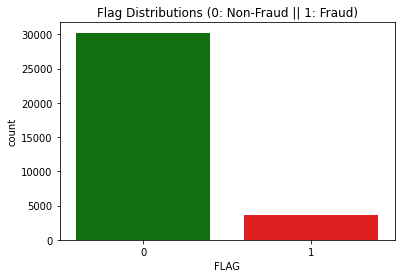

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

colors = ["green", "red"]
sns.countplot('FLAG', data=dataset, palette=colors)
plt.title('Flag Distributions (0: Non-Fraud || 1: Fraud)')

print('No Frauds', round(dataset['FLAG'].value_counts()[0]/len(dataset) * 100,2), '% of the dataset:', dataset['FLAG'].value_counts()[0])
print('Frauds', round(dataset['FLAG'].value_counts()[1]/len(dataset) * 100,2), '% of the dataset:', dataset['FLAG'].value_counts()[1])

In [ ]:
# Separating the dependent and independent variables 

X = dataset.drop('FLAG', axis = 1) 
#X = X.drop('Total_Consumption', axis = 1) 
y = dataset['FLAG'] 

In [ ]:
# # Separating train, validation and test set then undersample with PSO 

# # Separating train, validation and test set
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=59)
# #X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.05, random_state=59)

# print("Before undersample PSO:")
# print("X_train:", X_train.shape, "Flag 1: ", y_train[y_train == 1].count(), "Flag 0: ", y_train[y_train == 0].count())
# print("X_test:", X_test.shape, "Flag 1: ", y_test[y_test == 1].count(), "Flag 0: ", y_test[y_test == 0].count())
# #print("X_val:", X_val.shape, "Flag 1: ", y_val[y_val == 1].count(), "Flag 0: ", y_val[y_val == 0].count())

In [ ]:
# # PSO undersampling using MAX distance

# # Create 2 separate df for FLAG = 0 and 1
# df_train =  X_train.copy()
# df_train['FLAG'] = y_train

# df_scaled_flag0 =  df_train[df_train.FLAG == 0]
# df_scaled_flag1 =  df_train[df_train.FLAG == 1]

# # Count total of FLAG 0 and 1
# cnt_flag0 = df_scaled_flag0[df_scaled_flag0.FLAG == 0].count()[0]
# cnt_flag1 = df_scaled_flag1[df_scaled_flag1.FLAG == 1].count()[0]

# start_time = datetime.now() 
# # PSO variables
# max_particles_position = cnt_flag0
# #max_particles_position = 100
# swarm_size = 30 # number of particles
# row = 0
# n_rows = int(round(cnt_flag1/2, 0))
# #n_rows = 5
# iteration = 0
# n_iterations = 10
# euc_distance = 0
# fitness_candidate = 0
# target = 1
# target_error = 1e-6

# # Variables to calculate the velocity
# #W = 0.5
# #c1 = 0.5
# #c2 = 0.9
# W = 0.9
# c1 = 0.5
# c2 = 0.3

# df_scaled_flag0_gbest_final = pd.DataFrame([])

# print(mytime)
# print("Rows: ", n_rows, " ", "Max Particle Position/Flag0: ", max_particles_position, " ", "Flag1: ", cnt_flag1, " ", "No of Particles: ", swarm_size, " ", "No of Iteration: ", n_iterations)
# while row < n_rows:
#   start_time2 = datetime.now() 
#   ###print("Row: ", row, " ", "Max Particle Position: ", max_particles_position, " ", "No of Particles: ", swarm_size, " ", "No of Iteration: ", n_iterations) 

# # Define the fitness function. Calculate the distance between 2 rows using Euclidean Distance
#   def fitness_function(position):
#     #distance = scipy.spatial.distance.cdist(df_scaled_flag0.iloc[[position[0]]], df_scaled_flag0.iloc[[position[1]]], metric='euclidean')
#     distance = scipy.spatial.distance.cdist(df_scaled_flag0.iloc[[position[0]]], df_scaled_flag0.iloc[[position[1]]], metric='minkowski')
#     #distance = scipy.spatial.distance.cdist(df_scaled_flag0.iloc[[position[0]]], df_scaled_flag0.iloc[[position[1]]], metric='jaccard')
#     distance = np.round(distance, 2)
#     return(distance[0])

# # Set velocity initial value 
#   velocity_vector = ([np.array([0, 0]) for _ in range(swarm_size)])

# # Generate number ranging between 0 to max_particles_position for 2 dimensions of an array
#   particle_position_vector = np.random.randint(max_particles_position, size=(swarm_size, 2))

# # Set initial particle position, initial pbest position and value, initial gbest and value
#   pbest_position = particle_position_vector
#   pbest_fitness_value = np.array([float() for _ in range(swarm_size)])
#   gbest_fitness_value = float()
#   gbest_position = np.array([float('inf'), float('inf')])
#   best_iteration = np.array(float('inf'))
#   pbest_final = np.array([])
#   gbest_final = np.array([])

#   iteration = 0
#   while iteration < n_iterations:
#     #print("Iteration ", iteration) 

#     for i in range(swarm_size):
#         fitness_candidate = fitness_function(particle_position_vector[i])
#         #print(fitness_candidate, ' ', particle_position_vector[i], ' ', "iteration = ", iteration)
        
#         if (fitness_candidate == 0.):
#             #print("Fitness value equal", fitness_candidate, ' ', "Iteration = ", iteration)
#             fitness_candidate = pbest_fitness_value[i]
        
#         if (pbest_fitness_value[i] < fitness_candidate):
#             pbest_fitness_value[i] = fitness_candidate
#             pbest_position[i] = particle_position_vector[i]
#             pbest_result = np.array((pbest_position[i]))
#             pbest_final = np.append(pbest_final, pbest_result)
#             #print("Pbest =", pbest_fitness_value[i], ' ', "Pbest Position =", pbest_position[i], ' ', "Iterarion No =", iteration)

# # The maximum distance value - Gbest
#         if (gbest_fitness_value < fitness_candidate):
#             gbest_fitness_value = fitness_candidate
#             gbest_position = particle_position_vector[i]
#             best_iteration = iteration
#             gbest_result = np.array((gbest_position))
#             gbest_final = np.append(gbest_final, gbest_result)
#             #print("Gbest =", gbest_fitness_value, ' ', "Gbest Position =", gbest_position, ' ', "Iteration No =", iteration)
           
#     if (abs(gbest_fitness_value - target) < target_error):
#         break
        
#     for i in range(swarm_size):
#         new_velocity = (W * velocity_vector[i]) + (c1 * random.random()) * (pbest_position[i] - particle_position_vector[i]) + (c2 *random.random()) * (gbest_position - particle_position_vector[i])
#         new_position = new_velocity + particle_position_vector[i]
#         new_position = abs(np.round(new_position, 0))
#         particle_position_vector[i] = new_position

#     iteration = iteration + 1

#   elapsed_time = datetime.now() - start_time2
#   ###print("============================================================================================")
#   print("The best position is", gbest_position,". The gbest value is", gbest_fitness_value, "in iteration number", best_iteration, "in", elapsed_time)       
#   ###print("============================================================================================")
#   #print("Gbest position", gbest_final)
#   #print("=======================================================================================")
#   #print("Pbest position", pbest_final)

# # Create new df from Gbest positions 
#   df_scaled_flag0_gbest = pd.DataFrame.append(df_scaled_flag0.iloc[[gbest_position[0]]], df_scaled_flag0.iloc[[gbest_position[1]]])
#   df_scaled_flag0_gbest_final = df_scaled_flag0_gbest_final.append(df_scaled_flag0_gbest)

# # Remove the rows of the Gbest positions from the df
#   df_scaled_flag0 = df_scaled_flag0.drop([df_scaled_flag0.index[gbest_position[0]], df_scaled_flag0.index[gbest_position[1]]])
#   #df_scaled_flag0 = df_scaled_flag0.drop(df_scaled_flag0.index[gbest_position[1]])

#   cnt_flag0 = df_scaled_flag0.shape[0]

#   cnt_df_scaled_flag0_gbest_final = df_scaled_flag0_gbest_final.shape[0]
#   ###print("df_scaled_flag0_gbest_final rows: ", cnt_df_scaled_flag0_gbest_final, "/", cnt_flag1)

#   #if (cnt_df_scaled_flag0_gbest_final == cnt_flag1):
#     #break
  
#   # Number of particles minus the dropped rows
#   max_particles_position = max_particles_position - 2
#   row = row + 1
#   ###print('PSO Iteration Time elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - start_time2))

# print('PSO Iteration Time elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - start_time))

# # Write to csv file
# #df_scaled_flag0_gbest_final.to_csv("sgcc-pso-ANN-v5-gbest-max.csv")

# print(mytime)
# print("PSO Iteration DONE")

In [ ]:
# PSO undersampling using MIN distance

# Create 2 separate df for FLAG = 0 and 1
df_train =  dataset.copy()

df_scaled_flag0 =  df_train[df_train.FLAG == 0]
df_scaled_flag1 =  df_train[df_train.FLAG == 1]

# Count total of FLAG 0 and 1
cnt_flag0 = df_train[df_train.FLAG == 0].count()[0]
cnt_flag1 = df_train[df_train.FLAG == 1].count()[0]

start_time = datetime.now() 
# PSO variables
max_particles_position = cnt_flag0
#max_particles_position = 100
swarm_size = 10 # number of particles
row = 0
n_rows = cnt_flag0 - cnt_flag1
#n_rows = 5
iteration = 0
n_iterations = 3
euc_distance = 0
fitness_candidate = 0
target = 1
target_error = 1e-6

# Variables to calculate the velocity
W = 0.5
c1 = 0.5
c2 = 0.9

df_scaled_flag0_gbest_final = pd.DataFrame([])

mytime = datetime.now(malaysia)
print(mytime)
print("Rows: ", n_rows, " ", "Max Particle Position/Flag0: ", max_particles_position, " ", "Flag1: ", cnt_flag1, " ", "No of Particles: ", swarm_size, " ", "No of Iteration: ", n_iterations)
while row < n_rows:
  start_time2 = datetime.now() 
  ###print("Row: ", row, " ", "Max Particle Position: ", max_particles_position, " ", "No of Particles: ", swarm_size, " ", "No of Iteration: ", n_iterations) 

# Define the fitness function. Calculate the distance between 2 rows using Euclidean Distance
  def fitness_function(position):
    #distance = scipy.spatial.distance.cdist(df_scaled_flag0.iloc[[position[0]]], df_scaled_flag0.iloc[[position[1]]], metric='euclidean')
    distance = scipy.spatial.distance.cdist(df_scaled_flag0.iloc[[position[0]]], df_scaled_flag0.iloc[[position[1]]], metric='minkowski')
    #distance = scipy.spatial.distance.cdist(df_scaled_flag0.iloc[[position[0]]], df_scaled_flag0.iloc[[position[1]]], metric='jaccard')
    distance = np.round(distance, 2)
    return(distance[0])

# Set velocity initial value 
  velocity_vector = ([np.array([0, 0]) for _ in range(swarm_size)])

# Generate number ranging between 0 to max_particles_position for 2 dimensions of an array
  particle_position_vector = np.random.randint(max_particles_position, size=(swarm_size, 2))

# Set initial particle position, initial pbest position and value, initial gbest and value
  pbest_position = particle_position_vector
  pbest_fitness_value = np.array([float('inf') for _ in range(swarm_size)])
  gbest_fitness_value = float('inf')
  gbest_position = np.array([float('inf'), float('inf')])
  best_iteration = np.array(float('inf'))
  pbest_final = np.array([])
  gbest_final = np.array([])

  iteration = 0
  while iteration < n_iterations:
    #print("Iteration ", iteration) 

    for i in range(swarm_size):
        fitness_candidate = fitness_function(particle_position_vector[i])
        #print(fitness_candidate, ' ', particle_position_vector[i], ' ', "iteration = ", iteration)
        
        if (fitness_candidate == 0.):
            #print("Fitness value equal", fitness_candidate, ' ', "Iteration = ", iteration)
            fitness_candidate = pbest_fitness_value[i]
        
        if (pbest_fitness_value[i] > fitness_candidate):
            pbest_fitness_value[i] = fitness_candidate
            pbest_position[i] = particle_position_vector[i]
            pbest_result = np.array((pbest_position[i]))
            pbest_final = np.append(pbest_final, pbest_result)
            #print("Pbest =", pbest_fitness_value[i], ' ', "Pbest Position =", pbest_position[i], ' ', "Iterarion No =", iteration)

# The maximum distance value - Gbest
        if (gbest_fitness_value > fitness_candidate):
            gbest_fitness_value = fitness_candidate
            gbest_position = particle_position_vector[i]
            best_iteration = iteration
            gbest_result = np.array((gbest_position))
            gbest_final = np.append(gbest_final, gbest_result)
            #print("Gbest =", gbest_fitness_value, ' ', "Gbest Position =", gbest_position, ' ', "Iteration No =", iteration)
           
    if (abs(gbest_fitness_value - target) < target_error):
        break
        
    for i in range(swarm_size):
        new_velocity = (W * velocity_vector[i]) + (c1 * random.random()) * (pbest_position[i] - particle_position_vector[i]) + (c2 *random.random()) * (gbest_position - particle_position_vector[i])
        new_position = new_velocity + particle_position_vector[i]
        new_position = abs(np.round(new_position, 0))
        particle_position_vector[i] = new_position

    iteration = iteration + 1

  ###print("============================================================================================")
  #print("The best position is", gbest_position,". The gbest value is", gbest_fitness_value, "in iteration number", best_iteration)       
  ###print("============================================================================================")
  #print("Gbest position", gbest_final)
  #print("=======================================================================================")
  #print("Pbest position", pbest_final)

# Remove the row with low zero values from the df
  if (np.count_nonzero(df_scaled_flag0.iloc[[gbest_position[0]]]) >= np.count_nonzero(df_scaled_flag0.iloc[[gbest_position[1]]])):
    df_scaled_flag0 = df_scaled_flag0.drop(df_scaled_flag0.index[gbest_position[1]])
  else:
    df_scaled_flag0 = df_scaled_flag0.drop(df_scaled_flag0.index[gbest_position[0]])
  
  cnt_flag0 = df_scaled_flag0.shape[0]
  ###print("df_scaled_flag0 rows: ", cnt_flag0, "/", cnt_flag1)

  if (cnt_flag0 == 15000) or (cnt_flag0 == 13000) or (cnt_flag0 == 11000) or (cnt_flag0 == 9000) or (cnt_flag0 == 7000) or (cnt_flag0 == 5000) or (cnt_flag0 == 3500):
    print("df_scaled_flag0 rows: ", cnt_flag0, "/", cnt_flag1)
    print('Iteration Time elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - start_time))
    mytime = datetime.now(malaysia)
    print(mytime)
  
  #if (cnt_flag0 == cnt_flag1):
    #break

  # Number of particles minus the dropped row
  max_particles_position = max_particles_position - 1
  row = row + 1
  ###print('PSO Time elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - start_time2))

print('PSO Iteration Time elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - start_time))

# Write to csv file
df_scaled_flag0_gbest_final = df_scaled_flag0 
#df_scaled_flag0_gbest_final.to_csv("sgcc-pso-ANN-v5-gbest-min.csv")

mytime = datetime.now(malaysia)
print(mytime)
print("PSO Iteration DONE")

2020-03-19 15:19:30.283895+08:00
Rows:  26611   Max Particle Position/Flag0:  30226   Flag1:  3615   No of Particles:  10   No of Iteration:  3
df_scaled_flag0 rows:  15000 / 3615
Iteration Time elapsed (hh:mm:ss.ms) 0:08:11.210304
2020-03-19 15:27:41.493580+08:00
df_scaled_flag0 rows:  13000 / 3615
Iteration Time elapsed (hh:mm:ss.ms) 0:09:14.119086
2020-03-19 15:28:44.402435+08:00
df_scaled_flag0 rows:  11000 / 3615
Iteration Time elapsed (hh:mm:ss.ms) 0:10:16.631365
2020-03-19 15:29:46.914604+08:00
df_scaled_flag0 rows:  9000 / 3615
Iteration Time elapsed (hh:mm:ss.ms) 0:11:18.674826
2020-03-19 15:30:48.958056+08:00
df_scaled_flag0 rows:  7000 / 3615
Iteration Time elapsed (hh:mm:ss.ms) 0:12:20.412114
2020-03-19 15:31:50.695389+08:00
df_scaled_flag0 rows:  5000 / 3615
Iteration Time elapsed (hh:mm:ss.ms) 0:13:21.459229
2020-03-19 15:32:51.742460+08:00
PSO Iteration Time elapsed (hh:mm:ss.ms) 0:14:03.276589
2020-03-19 15:33:33.559972+08:00
PSO Iteration DONE


In [ ]:
df_scaled_flag0_gbest_final

,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,Total_Consumption,FLAG
3615,0.440375,0.330824,0.384403,0.403254,0.453112,0.467288,0.481438,0.411049,0.431765,0.608051,0.441683,0.427812,0.421815,0.360503,0.398326,0.415234,0.414096,0.398141,0.392535,0.382551,0.386496,0.376098,0.364940,0.348950,0.494039,1.026542,0.045833,0.221776,0.319514,0.188765,-0.073657,0.412851,0.808169,0.584760,0.386332,0
3617,-2.044429,-1.780317,-1.846044,-2.387962,-2.265959,-1.354822,-2.129692,-2.072957,-2.061134,-1.597210,-2.039928,-2.064000,-2.043171,0.032757,0.398326,0.415234,0.414096,0.398141,0.392535,0.382551,0.386496,0.376098,0.364940,0.348950,-1.791572,-1.806856,-1.786796,-1.780578,-1.797116,-1.766498,-1.745636,-1.768215,-0.584469,-1.785730,-0.796277,0
3618,-2.044429,-2.405642,-2.461474,-2.387962,-2.265959,-2.215799,-2.129692,-2.072957,-2.061134,-1.724567,-2.039928,0.528113,0.664190,0.409305,0.398326,0.415234,0.323731,0.079008,-0.013334,0.052544,0.117684,0.129568,0.171790,0.122050,0.317008,0.178101,0.092661,0.130031,0.197299,0.150938,0.167647,0.175067,0.204676,0.274729,-0.316564,0
3620,-0.750872,-0.311410,1.081276,0.887107,0.403446,-0.123602,-0.312898,-0.248598,0.176222,1.008946,1.034344,1.137016,1.031183,1.016734,0.855581,0.570896,0.492325,0.139715,-0.155738,0.010811,0.065679,0.203630,0.206915,0.323778,0.599055,0.647043,0.683037,0.652653,0.330338,0.224780,0.113137,0.083761,0.219738,0.247609,0.364022,0
3623,-2.044429,-1.602856,-1.679098,-0.718352,2.348427,1.191248,0.051515,0.667451,1.064967,1.823725,1.269587,1.945363,1.675496,2.004694,1.833736,1.428462,1.553974,0.706410,0.484454,0.821693,2.450969,0.276720,-0.076303,-0.010755,0.173667,0.570850,0.191612,0.412710,0.402383,0.112367,-0.026395,-0.088336,0.154276,0.229774,0.904336,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33827,-2.044429,-2.405642,-2.461474,-2.387962,-2.265959,-2.215799,-0.946529,-2.072957,-0.189736,1.191129,1.035314,1.115460,1.015043,0.760666,1.068048,1.111172,1.173753,1.198864,1.154343,1.147414,1.027560,1.033507,1.220163,1.120106,0.829022,0.739594,0.966293,0.930160,0.912381,1.052707,0.989340,0.940019,1.002731,0.849924,0.776088,0
33829,5.257260,6.600212,5.124923,4.846381,4.165944,3.858965,2.976983,3.305216,3.313184,3.264544,4.003449,4.348370,4.556238,5.706991,4.451379,4.351883,4.456825,3.686688,3.649999,3.965738,4.291345,4.907226,5.035882,5.142232,3.295501,3.636460,3.104525,3.168398,2.704150,2.426587,2.266484,2.271697,2.755113,2.938352,3.922675,0
33830,0.440375,0.330824,0.384403,0.403254,0.453112,0.467288,0.481438,0.411049,0.431765,0.608051,0.441683,0.427812,0.421815,0.360503,0.398326,0.415234,0.414096,0.398141,0.392535,0.382551,0.386496,0.376098,0.364940,0.348950,0.649785,0.125198,0.458960,0.359832,0.566041,0.709542,0.691793,-0.063810,-0.535083,-1.781198,0.349765,0
33833,-2.030949,-2.400028,-2.449793,-0.540647,-0.418669,-2.155582,-2.129692,-2.068310,-2.059438,-1.724265,-2.037980,-2.062190,-1.905394,-1.157651,-1.916590,-0.401893,-0.736456,-0.772050,-1.019839,-1.002260,-0.723802,-0.415305,-0.245737,-0.098387,-0.027863,-0.358389,-0.291109,-0.262236,-0.755444,-1.764385,-0.701018,-0.671773,-0.581351,-0.540220,-1.392984,0


In [ ]:
# Combine this undersampled FLAG0 df with df FLAG1

df_sgcc_balance_pso = pd.concat([df_scaled_flag0_gbest_final, df_scaled_flag1])
df_sgcc_balance_pso = df_sgcc_balance_pso.reset_index()
df_sgcc_balance_pso = df_sgcc_balance_pso.iloc[:,1:]
df_sgcc_balance_pso

,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,Total_Consumption,FLAG
0,0.440375,0.330824,0.384403,0.403254,0.453112,0.467288,0.481438,0.411049,0.431765,0.608051,0.441683,0.427812,0.421815,0.360503,0.398326,0.415234,0.414096,0.398141,0.392535,0.382551,0.386496,0.376098,0.364940,0.348950,0.494039,1.026542,0.045833,0.221776,0.319514,0.188765,-0.073657,0.412851,0.808169,0.584760,0.386332,0
1,-2.044429,-1.780317,-1.846044,-2.387962,-2.265959,-1.354822,-2.129692,-2.072957,-2.061134,-1.597210,-2.039928,-2.064000,-2.043171,0.032757,0.398326,0.415234,0.414096,0.398141,0.392535,0.382551,0.386496,0.376098,0.364940,0.348950,-1.791572,-1.806856,-1.786796,-1.780578,-1.797116,-1.766498,-1.745636,-1.768215,-0.584469,-1.785730,-0.796277,0
2,-2.044429,-2.405642,-2.461474,-2.387962,-2.265959,-2.215799,-2.129692,-2.072957,-2.061134,-1.724567,-2.039928,0.528113,0.664190,0.409305,0.398326,0.415234,0.323731,0.079008,-0.013334,0.052544,0.117684,0.129568,0.171790,0.122050,0.317008,0.178101,0.092661,0.130031,0.197299,0.150938,0.167647,0.175067,0.204676,0.274729,-0.316564,0
3,-0.750872,-0.311410,1.081276,0.887107,0.403446,-0.123602,-0.312898,-0.248598,0.176222,1.008946,1.034344,1.137016,1.031183,1.016734,0.855581,0.570896,0.492325,0.139715,-0.155738,0.010811,0.065679,0.203630,0.206915,0.323778,0.599055,0.647043,0.683037,0.652653,0.330338,0.224780,0.113137,0.083761,0.219738,0.247609,0.364022,0
4,-2.044429,-1.602856,-1.679098,-0.718352,2.348427,1.191248,0.051515,0.667451,1.064967,1.823725,1.269587,1.945363,1.675496,2.004694,1.833736,1.428462,1.553974,0.706410,0.484454,0.821693,2.450969,0.276720,-0.076303,-0.010755,0.173667,0.570850,0.191612,0.412710,0.402383,0.112367,-0.026395,-0.088336,0.154276,0.229774,0.904336,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7225,0.440375,0.330824,0.384403,0.403254,0.453112,0.467288,0.481438,0.411049,0.431765,0.608051,0.441683,0.427812,0.421815,0.360503,0.398326,0.415234,0.414096,0.398141,0.392535,0.382551,0.386496,0.376098,0.364940,0.348950,1.616035,1.665263,1.585114,1.280382,1.121159,1.225682,1.360829,1.298171,1.140944,0.724414,0.957800,1
7226,-2.044429,-2.405642,-2.461474,-2.387962,-2.265959,-2.215799,-2.129692,-2.072957,-2.061134,-1.724567,-1.227521,-2.064000,-2.043171,-0.605086,-1.147221,-1.136648,-1.153931,-1.189500,-0.963124,-0.837524,-1.044593,-1.040149,-0.813431,-0.355031,-0.685431,-0.070872,-0.995306,-1.569661,-1.673275,-1.656189,-1.474871,-1.440363,-0.290695,-1.598091,-1.810545,1
7227,0.440375,0.330824,0.384403,0.403254,0.453112,0.467288,0.481438,0.411049,0.431765,0.608051,0.441683,0.427812,0.421815,0.169469,-1.534335,-1.396419,-1.395516,-1.466344,-1.464973,-1.480248,-1.449386,0.653086,1.315700,-0.501473,-0.196130,-0.776121,-0.801819,-0.489057,-0.102600,0.091357,0.222848,0.444557,1.102343,1.395211,0.126113,1
7228,2.627527,2.644408,3.574555,3.949262,3.933905,4.112663,3.663222,3.360746,3.415570,3.113358,0.949192,0.110795,0.088732,-0.458224,0.132353,0.238243,0.222860,1.990995,3.113701,3.091280,4.468935,6.084605,6.528445,6.700330,3.596969,3.533547,3.890294,3.978312,3.683535,3.122288,2.700240,2.690041,3.152812,4.250823,3.796713,1


In [ ]:
# Undersample with PSO then separating train, validation and test set 

# Separating the dependent and independent variables 
X_pso = df_sgcc_balance_pso.drop('FLAG', axis = 1) 
y_pso = df_sgcc_balance_pso['FLAG'] 

X_pso = pd.DataFrame(X_pso)
y_pso = pd.Series(y_pso)

# Separating train, validation and test set
X_train, X_test, y_train, y_test = train_test_split(X_pso, y_pso, test_size=0.1, random_state=49)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=49)

#print("After undersample PSO:")
#print("X_train:", X_train.shape, "Flag 1: ", y_train[y_train == 1].count(), "Flag 0: ", y_train[y_train == 0].count())
#print("X_test:", X_test.shape, "Flag 1: ", y_test[y_test == 1].count(), "Flag 0: ", y_test[y_test == 0].count())
#print("X_val:", X_val.shape, "Flag 1: ", y_val[y_val == 1].count(), "Flag 0: ", y_val[y_val == 0].count())

After PSO GA :
X_train:
No Frauds 50.34 % of the dataset: 2620
Frauds 49.66 % of the dataset: 2585

X_test:
No Frauds 47.3 % of the dataset: 342
Frauds 52.7 % of the dataset: 381

X_val:
No Frauds 50.15 % of the dataset: 653
Frauds 49.85 % of the dataset: 649


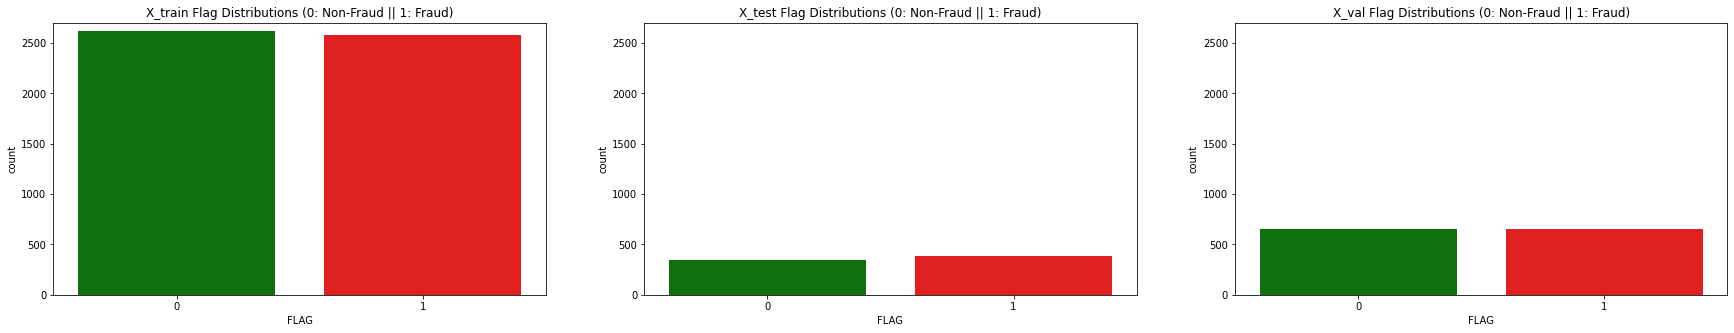

In [ ]:
# Plotting the sets

fig, ax = plt.subplots(1, 3, figsize=(30, 5))
plt.subplot(1, 3, 1)
colors = ["green", "red"]
df_train = pd.DataFrame(y_train.value_counts())
ax = sns.countplot(y_train, data=df_train, palette=colors)
ax.set_ylim(0, 2700)
plt.title('X_train Flag Distributions (0: Non-Fraud || 1: Fraud)')

plt.subplot(1, 3, 2)
colors = ["green", "red"]
df_train = pd.DataFrame(y_test.value_counts())
ax = sns.countplot(y_test, data=df_train, palette=colors)
ax.set_ylim(0, 2700)
plt.title('X_test Flag Distributions (0: Non-Fraud || 1: Fraud)')

plt.subplot(1, 3, 3)
colors = ["green", "red"]
df_train = pd.DataFrame(y_val.value_counts())
ax = sns.countplot(y_val, data=df_train, palette=colors)
ax.set_ylim(0, 2700)
plt.title('X_val Flag Distributions (0: Non-Fraud || 1: Fraud)')

print("After", program_name, ":")
print("X_train:")
print('No Frauds', round(y_train.value_counts()[0]/len(y_train) * 100,2), '% of the dataset:', y_train.value_counts()[0])
print('Frauds', round(y_train.value_counts()[1]/len(y_train) * 100,2), '% of the dataset:', y_train.value_counts()[1])
print("")
print("X_test:")
print('No Frauds', round(y_test.value_counts()[0]/len(y_test) * 100,2), '% of the dataset:', y_test.value_counts()[0])
print('Frauds', round(y_test.value_counts()[1]/len(y_test) * 100,2), '% of the dataset:', y_test.value_counts()[1])
print("")
print("X_val:")
print('No Frauds', round(y_val.value_counts()[0]/len(y_val) * 100,2), '% of the dataset:', y_val.value_counts()[0])
print('Frauds', round(y_val.value_counts()[1]/len(y_val) * 100,2), '% of the dataset:', y_val.value_counts()[1])

plt.show()

In [ ]:
# GA ANN. Parameters tuning using Validation set
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

classifier = str(MLPClassifier())[0:3]
clf_start_time = classifier + '_start_time' 
clf_start_time = datetime.now()

def initialize_population_mlp(size_mlp):
    activation = ['identity','logistic', 'tanh', 'relu']
    solver = ['lbfgs','sgd', 'adam']
    pop =  np.array([[random.choice(activation), random.choice(solver), randint(2,100),randint(2,50)]])
    for i in range(0, size_mlp-1):
        pop = np.append(pop, [[random.choice(activation), random.choice(solver), randint(2,50),randint(2,50)]], axis=0)
    print("Random Parameters Population: ", pop)
    return pop

def crossing_mlp(parent_1, parent_2):
    child = [parent_1[0], parent_2[1], parent_1[2], parent_2[3]]    
    return child

def mutation_mlp(child, prob_mut):
    child_ = np.copy(child)
    for c in range(0, len(child_)):
        if np.random.rand() >= prob_mut:
            k = randint(2,3)
            child_[c,k] = int(child_[c,k]) + randint(1, 4)
    return child_

def function_fitness_mlp(pop, X_train, y_train, X_val, y_val): 
    fitness_start_time = datetime.now()
    fitness = []
    j = 0
    for w in pop:
        clf = MLPClassifier(learning_rate_init=0.09, activation=w[0], solver = w[1], alpha=1e-5, hidden_layer_sizes=(int(w[2]), int(w[3])), max_iter=1100, n_iter_no_change=80)

        try:
            clf.fit(X_train, y_train)
            #f = f1_score(clf.predict(X_val), y_val, average='weighted')  
            f = f1_score(clf.predict(X_val), y_val, pos_label=1, average='macro')        

            fitness.append([f, clf, w])
        except:
            pass
    #print('Parameters Population : ', w)  
    print('Fitness Value :', f)
    print('Fitness elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - fitness_start_time))     
    return fitness

def ag_mlp(X_train, y_train, X_val, y_val, num_epochs = 10, size_mlp=10, prob_mut=0.8):
    pop = initialize_population_mlp(size_mlp)
    fitness = function_fitness_mlp(pop, X_train, y_train, X_val, y_val)
    pop_fitness_sort = np.array(list(reversed(sorted(fitness,key=lambda x: x[0]))))

    for j in range(0, num_epochs):
        length = len(pop_fitness_sort)
        # Select parents
        parent_1 = pop_fitness_sort[:,2][:length//2]
        parent_2 = pop_fitness_sort[:,2][length//2:]

        # Crossing
        child_1 = [crossing_mlp(parent_1[i], parent_2[i]) for i in range(0, np.min([len(parent_2), len(parent_1)]))]
        child_2 = [crossing_mlp(parent_2[i], parent_1[i]) for i in range(0, np.min([len(parent_2), len(parent_1)]))]
        child_2 = mutation_mlp(child_2, prob_mut)
        
        # Calculates children's fitness to choose who will pass to the next generation
        fitness_child_1 = function_fitness_mlp(child_1, X_train, y_train, X_val, y_val)
        fitness_child_2 = function_fitness_mlp(child_2, X_train, y_train, X_val, y_val)
        pop_fitness_sort = np.concatenate((pop_fitness_sort, fitness_child_1, fitness_child_2))
        sort = np.array(list(reversed(sorted(pop_fitness_sort,key=lambda x: x[0]))))
        
        # Selects individuals of the next generation
        pop_fitness_sort = sort[0:size_mlp, :]
        best_individual = sort[0][1]
           
    return best_individual

clf_best_result = classifier + '_best_result' 
clf_best_result = ag_mlp(X_train, y_train, X_val, y_val, num_epochs = 5, size_mlp=10, prob_mut=0.1)
print("ANN Best Result for Validation Set:\n", clf_best_result)
y_pred = clf_best_result.predict(X_val)
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))
print("Accuracy : ", accuracy_score(y_val, y_pred))
print("F1 Score : ", f1_score(y_val, y_pred, pos_label=1, average='macro'))
mlp_best_result = clf_best_result
print('GA ANN elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - clf_start_time))
print(mytime)

Random Parameters Population:  [['tanh' 'sgd' '18' '24']
 ['tanh' 'adam' '17' '22']
 ['tanh' 'adam' '49' '18']
 ['logistic' 'lbfgs' '29' '15']
 ['logistic' 'adam' '16' '22']
 ['tanh' 'sgd' '2' '6']
 ['relu' 'lbfgs' '9' '41']
 ['identity' 'sgd' '16' '19']
 ['identity' 'adam' '45' '30']
 ['identity' 'adam' '27' '43']]
Fitness Value : 0.7310203166133469
Fitness elapsed (hh:mm:ss.ms) 0:01:08.369363
Fitness Value : 0.7103960965594145
Fitness elapsed (hh:mm:ss.ms) 0:00:59.199552
Fitness Value : 0.7158110834503344
Fitness elapsed (hh:mm:ss.ms) 0:00:16.543421
Fitness Value : 0.7108833332939617
Fitness elapsed (hh:mm:ss.ms) 0:00:31.242780
Fitness Value : 0.7040355249477027
Fitness elapsed (hh:mm:ss.ms) 0:00:26.913701
Fitness Value : 0.7380913756010428
Fitness elapsed (hh:mm:ss.ms) 0:00:33.816472
Fitness Value : 0.744947498353792
Fitness elapsed (hh:mm:ss.ms) 0:00:37.788683
Fitness Value : 0.7680766226826159
Fitness elapsed (hh:mm:ss.ms) 0:00:24.539334
Fitness Value : 0.7237349354504166
Fitness 

In [ ]:
# GA SVC. Parameters tuning using Validation set
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

classifier = str(SVC())[0:3]
clf_start_time = classifier + '_start_time' 
clf_start_time = datetime.now()

def initialize_population_mlp(size_mlp):
    kernels = ['linear','rbf', 'poly', 'sigmoid']
    gammas = ['scale', 'auto']
    Cs = [0.001, 0.01, 0.1, 1, 10]
    degrees = [0, 1, 2, 3, 4, 5, 6]
    pop =  np.array([[random.choice(kernels), random.choice(gammas), random.choice(Cs), random.choice(degrees)]])
    for i in range(0, size_mlp-1):
        pop = np.append(pop, [[random.choice(kernels), random.choice(gammas), random.choice(Cs), random.choice(degrees)]], axis=0)
    print("Random Parameters Population: ", pop)
    return pop

def crossing_mlp(parent_1, parent_2):
    child = [parent_1[0], parent_2[1], parent_1[2], parent_2[3]]    
    return child

def mutation_mlp(child, prob_mut):
    child_ = np.copy(child)
    for c in range(0, len(child_)):
        if np.random.rand() >= prob_mut:
            k = randint(2,3)
            #child_[c,k] = int(child_[c,k]) + randint(1, 4)
            child_[c,k] = float(child_[c,k]) + randint(1, 4)
    return child_

def function_fitness_mlp(pop, X_train, y_train, X_val, y_val): 
    fitness_start_time = datetime.now()
    fitness = []
    j = 0
    for w in pop:
        clf = SVC(kernel=w[0], C=float(w[2]), gamma=w[1], degree=float(w[3]), class_weight='balanced', probability=True)
               
        try:
            clf.fit(X_train, y_train)
            #f = f1_score(clf.predict(X_val), y_val, average='weighted')  
            f = f1_score(clf.predict(X_val), y_val, pos_label=1, average='macro')         

            fitness.append([f, clf, w])
        except:
            pass
    #print('Parameters Population : ', w)  
    print('Fitness Value :', f)
    print('Fitness elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - fitness_start_time))     
    return fitness

def ag_mlp(X_train, y_train, X_val, y_val, num_epochs = 10, size_mlp=10, prob_mut=0.8):
    pop = initialize_population_mlp(size_mlp)
    fitness = function_fitness_mlp(pop, X_train, y_train, X_val, y_val)
    pop_fitness_sort = np.array(list(reversed(sorted(fitness,key=lambda x: x[0]))))
    
    for j in range(0, num_epochs):
        length = len(pop_fitness_sort)
        # Select parents
        parent_1 = pop_fitness_sort[:,2][:length//2]
        parent_2 = pop_fitness_sort[:,2][length//2:]

        # Crossing
        child_1 = [crossing_mlp(parent_1[i], parent_2[i]) for i in range(0, np.min([len(parent_2), len(parent_1)]))]
        child_2 = [crossing_mlp(parent_2[i], parent_1[i]) for i in range(0, np.min([len(parent_2), len(parent_1)]))]
        child_2 = mutation_mlp(child_2, prob_mut)
        
        # Calculates children's fitness to choose who will pass to the next generation
        fitness_child_1 = function_fitness_mlp(child_1, X_train, y_train, X_val, y_val)
        fitness_child_2 = function_fitness_mlp(child_2, X_train, y_train, X_val, y_val)
        pop_fitness_sort = np.concatenate((pop_fitness_sort, fitness_child_1, fitness_child_2))
        sort = np.array(list(reversed(sorted(pop_fitness_sort,key=lambda x: x[0]))))
        
        # Selects individuals of the next generation
        pop_fitness_sort = sort[0:size_mlp, :]
        best_individual = sort[0][1]
           
    return best_individual

clf_best_result = classifier + '_best_result' 
clf_best_result = ag_mlp(X_train, y_train, X_val, y_val, num_epochs = 5, size_mlp=10, prob_mut=0.1)
print("SVC Best Result for Validation Set:\n", clf_best_result)
y_pred = clf_best_result.predict(X_val)
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))
print("Accuracy : ", accuracy_score(y_val, y_pred))
print("F1 Score : ", f1_score(y_val, y_pred, pos_label=1, average='macro'))
svc_best_result = clf_best_result
print('GA SVC elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - clf_start_time))
print(mytime)

Random Parameters Population:  [['poly' 'auto' '10' '0']
 ['sigmoid' 'auto' '0.01' '2']
 ['sigmoid' 'auto' '0.01' '4']
 ['poly' 'auto' '0.1' '5']
 ['poly' 'auto' '10' '1']
 ['rbf' 'scale' '10' '1']
 ['poly' 'scale' '0.01' '4']
 ['rbf' 'scale' '0.001' '1']
 ['rbf' 'scale' '1' '3']
 ['sigmoid' 'scale' '0.01' '3']]
Fitness Value : 0.6688618961794202
Fitness elapsed (hh:mm:ss.ms) 0:02:14.122910
Fitness Value : 0.6399762986371715
Fitness elapsed (hh:mm:ss.ms) 0:06:04.662298
Fitness Value : 0.7063528247710694
Fitness elapsed (hh:mm:ss.ms) 0:01:03.461488
Fitness Value : 0.6982265411330717
Fitness elapsed (hh:mm:ss.ms) 0:01:59.374447
Fitness Value : 0.7243867690046308
Fitness elapsed (hh:mm:ss.ms) 0:06:09.096652
Fitness Value : 0.7687024563213432
Fitness elapsed (hh:mm:ss.ms) 0:00:45.917319
Fitness Value : 0.7207478575762172
Fitness elapsed (hh:mm:ss.ms) 0:00:54.394804
Fitness Value : 0.7794885927419141
Fitness elapsed (hh:mm:ss.ms) 0:00:47.973338
Fitness Value : 0.7687024563213432
Fitness ela

In [ ]:
# GA XGBoost. Parameters tuning using Validation set
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

n_scale_pos_weight = cnt_flag0/cnt_flag1

classifier = str(XGBClassifier())[0:3]
clf_start_time = classifier + '_start_time' 
clf_start_time = datetime.now()

def initialize_population_mlp(size_mlp):
    np.set_printoptions(suppress=True)
    colsample_bytree = [0.3, 0.4, 0.5, 0.7, 1]
    subsample = [0.7, 0.75, 0.8, 0.85]
    pop =  np.array([[random.choice(colsample_bytree), random.choice(subsample), randint(2,10), randint(1,12)]])
    for i in range(0, size_mlp-1):
        pop = np.append(pop, [[random.choice(colsample_bytree), random.choice(subsample), randint(2,10), randint(1,12)]], axis=0)
    print("Random Parameters Population: ", pop)
    return pop

def crossing_mlp(parent_1, parent_2):
    child = [parent_1[0], parent_2[1], parent_1[2], parent_2[3]]    
    return child

def mutation_mlp(child, prob_mut):
    child_ = np.copy(child)
    for c in range(0, len(child_)):
        if np.random.rand() >= prob_mut:
            k = randint(2,3)
            #child_[c,k] = int(child_[c,k]) + randint(1, 4)
            child_[c,k] = float(child_[c,k]) + randint(1, 4)
    return child_

def function_fitness_mlp(pop, X_train, y_train, X_val, y_val): 
    fitness_start_time = datetime.now()
    fitness = []
    j = 0
    for w in pop:
        clf = XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=int(w[2]), min_child_weight=w[3], gamma=0, reg_alpha=0.005, subsample=w[1], colsample_bytree=w[0], objective='binary:logistic', nthread=4, scale_pos_weight=n_scale_pos_weight, seed=27)
        
        try:
            clf.fit(X_train, y_train)
            #f = f1_score(clf.predict(X_val), y_val, average='weighted')  
            f = f1_score(clf.predict(X_val), y_val, pos_label=1, average='macro')        

            fitness.append([f, clf, w])
        except:
            pass
    #print('Parameters Population : ', w)  
    print('Fitness Value :', f)
    print('Fitness elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - fitness_start_time))     
    return fitness

def ag_mlp(X_train, y_train, X_val, y_val, num_epochs = 5, size_mlp=10, prob_mut=0.8):
    pop = initialize_population_mlp(size_mlp)
    fitness = function_fitness_mlp(pop, X_train, y_train, X_val, y_val)
    pop_fitness_sort = np.array(list(reversed(sorted(fitness,key=lambda x: x[0]))))

    for j in range(0, num_epochs):
        length = len(pop_fitness_sort)
        # Select parents
        parent_1 = pop_fitness_sort[:,2][:length//2]
        parent_2 = pop_fitness_sort[:,2][length//2:]

        # Crossing
        child_1 = [crossing_mlp(parent_1[i], parent_2[i]) for i in range(0, np.min([len(parent_2), len(parent_1)]))]
        child_2 = [crossing_mlp(parent_2[i], parent_1[i]) for i in range(0, np.min([len(parent_2), len(parent_1)]))]
        child_2 = mutation_mlp(child_2, prob_mut)
        
        # Calculates children's fitness to choose who will pass to the next generation
        fitness_child_1 = function_fitness_mlp(child_1, X_train, y_train, X_val, y_val)
        fitness_child_2 = function_fitness_mlp(child_2, X_train, y_train, X_val, y_val)
        pop_fitness_sort = np.concatenate((pop_fitness_sort, fitness_child_1, fitness_child_2))
        sort = np.array(list(reversed(sorted(pop_fitness_sort,key=lambda x: x[0]))))
        
        # Selects individuals of the next generation
        pop_fitness_sort = sort[0:size_mlp, :]
        best_individual = sort[0][1]
           
    return best_individual

clf_best_result = classifier + '_best_result' 
clf_best_result = ag_mlp(X_train, y_train, X_val, y_val, num_epochs = 10, size_mlp=10, prob_mut=0.1)
print("XGBoost Best Result for Validation Set:\n", clf_best_result)
y_pred = clf_best_result.predict(X_val)
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))
print("Accuracy : ", accuracy_score(y_val, y_pred))
print("F1 Score : ", f1_score(y_val, y_pred, pos_label=1, average='macro'))
xgboost_best_result = clf_best_result
print('GA XGBoost elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - clf_start_time))
print(mytime)

Random Parameters Population:  [[ 0.5   0.85  4.    1.  ]
 [ 0.4   0.75  4.    7.  ]
 [ 0.4   0.75  7.    8.  ]
 [ 0.3   0.85  2.    2.  ]
 [ 1.    0.8   6.   10.  ]
 [ 0.5   0.7   5.    7.  ]
 [ 0.3   0.7   8.    3.  ]
 [ 1.    0.85  2.    2.  ]
 [ 0.5   0.7   3.    6.  ]
 [ 0.3   0.75  8.    2.  ]]
Fitness Value : 0.7746679700766984
Fitness elapsed (hh:mm:ss.ms) 0:00:09.286670
Fitness Value : 0.7754493564421933
Fitness elapsed (hh:mm:ss.ms) 0:00:06.419102
Fitness Value : 0.7511467889908257
Fitness elapsed (hh:mm:ss.ms) 0:00:03.769140
Fitness Value : 0.7801304200982049
Fitness elapsed (hh:mm:ss.ms) 0:00:06.975611
Fitness Value : 0.7768819491717722
Fitness elapsed (hh:mm:ss.ms) 0:00:05.862770
Fitness Value : 0.7777441752633647
Fitness elapsed (hh:mm:ss.ms) 0:00:06.781225
Fitness Value : 0.7772131762728905
Fitness elapsed (hh:mm:ss.ms) 0:00:06.987770
Fitness Value : 0.7802212589948438
Fitness elapsed (hh:mm:ss.ms) 0:00:06.398654
Fitness Value : 0.7749455336405355
Fitness elapsed (hh:mm:

In [ ]:
# GA RF. Parameters tuning using Validation set
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

classifier = str(RandomForestClassifier())[0:3]
clf_start_time = classifier + '_start_time' 
clf_start_time = datetime.now()

def initialize_population_mlp(size_mlp):
    np.set_printoptions(suppress=True)
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    min_samples_split = [2, 5, 10]
    min_samples_leaf = [1, 2, 4]
    pop =  np.array([[random.choice(n_estimators), random.choice(max_depth), random.choice(min_samples_split), random.choice(min_samples_leaf)]])
    for i in range(0, size_mlp-1):
        pop = np.append(pop, [[random.choice(n_estimators), random.choice(max_depth), random.choice(min_samples_split), random.choice(min_samples_leaf)]], axis=0)
    print("Random Parameters Population: ", pop)
    return pop

def crossing_mlp(parent_1, parent_2):
    child = [parent_1[0], parent_2[1], parent_1[2], parent_2[3]]    
    return child

def mutation_mlp(child, prob_mut):
    child_ = np.copy(child)
    for c in range(0, len(child_)):
        if np.random.rand() >= prob_mut:
            k = randint(2,3)
            #child_[c,k] = int(child_[c,k]) + randint(1, 4)
            child_[c,k] = float(child_[c,k]) + randint(1, 4)
    return child_

def function_fitness_mlp(pop, X_train, y_train, X_val, y_val): 
    fitness_start_time = datetime.now()
    fitness = []
    j = 0
    for w in pop:
        clf = RandomForestClassifier(n_estimators=w[0], max_depth=w[1], min_samples_split=w[2], min_samples_leaf=w[3], class_weight='balanced', random_state=0)
        
        try:
            clf.fit(X_train, y_train)
            #f = f1_score(clf.predict(X_val), y_val, average='weighted')  
            f = f1_score(clf.predict(X_val), y_val, pos_label=1, average='macro')         

            fitness.append([f, clf, w])
        except:
            pass
    #print('Parameters Population : ', w)  
    print('Fitness Value :', f)
    print('Fitness elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - fitness_start_time))     
    return fitness

def ag_mlp(X_train, y_train, X_val, y_val, num_epochs = 5, size_mlp=10, prob_mut=0.8):
    pop = initialize_population_mlp(size_mlp)
    fitness = function_fitness_mlp(pop, X_train, y_train, X_val, y_val)
    pop_fitness_sort = np.array(list(reversed(sorted(fitness,key=lambda x: x[0]))))

    for j in range(0, num_epochs):
        length = len(pop_fitness_sort)
        # Select parents
        parent_1 = pop_fitness_sort[:,2][:length//2]
        parent_2 = pop_fitness_sort[:,2][length//2:]

        # Crossing
        child_1 = [crossing_mlp(parent_1[i], parent_2[i]) for i in range(0, np.min([len(parent_2), len(parent_1)]))]
        child_2 = [crossing_mlp(parent_2[i], parent_1[i]) for i in range(0, np.min([len(parent_2), len(parent_1)]))]
        child_2 = mutation_mlp(child_2, prob_mut)
        
        # Calculates children's fitness to choose who will pass to the next generation
        fitness_child_1 = function_fitness_mlp(child_1, X_train, y_train, X_val, y_val)
        fitness_child_2 = function_fitness_mlp(child_2, X_train, y_train, X_val, y_val)
        pop_fitness_sort = np.concatenate((pop_fitness_sort, fitness_child_1, fitness_child_2))
        sort = np.array(list(reversed(sorted(pop_fitness_sort,key=lambda x: x[0]))))
        
        # Selects individuals of the next generation
        pop_fitness_sort = sort[0:size_mlp, :]
        best_individual = sort[0][1]
           
    return best_individual

clf_best_result = classifier + '_best_result' 
clf_best_result = ag_mlp(X_train, y_train, X_val, y_val, num_epochs = 10, size_mlp=10, prob_mut=0.1)
print("RF Best Result for Validation Set:\n", clf_best_result)
y_pred = clf_best_result.predict(X_val)
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))
print("Accuracy : ", accuracy_score(y_val, y_pred))
print("F1 Score : ", f1_score(y_val, y_pred, pos_label=1, average='macro'))
rf_best_result = clf_best_result
print('GA RF elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - clf_start_time))
print(mytime)

Random Parameters Population:  [[ 800   30    5    1]
 [2000   90    2    4]
 [ 800  110   10    2]
 [ 600  100   10    1]
 [1000   90   10    1]
 [1800   30   10    4]
 [1400   50    5    4]
 [1000   20    2    4]
 [1400   80    2    2]
 [1600   20    5    2]]
Fitness Value : 0.782745766322292
Fitness elapsed (hh:mm:ss.ms) 0:04:10.058824
Fitness Value : 0.78342069822853
Fitness elapsed (hh:mm:ss.ms) 0:02:10.095005
Fitness Value : 0.7773717682850708
Fitness elapsed (hh:mm:ss.ms) 0:01:58.514466
Fitness Value : 0.7857523374775368
Fitness elapsed (hh:mm:ss.ms) 0:01:24.207362
Fitness Value : 0.7796260699946973
Fitness elapsed (hh:mm:ss.ms) 0:02:35.114005
Fitness Value : 0.7819938076978374
Fitness elapsed (hh:mm:ss.ms) 0:02:08.684650
Fitness Value : 0.7819184542421516
Fitness elapsed (hh:mm:ss.ms) 0:01:29.894517
Fitness Value : 0.7840473702542669
Fitness elapsed (hh:mm:ss.ms) 0:01:59.892625
Fitness Value : 0.78342069822853
Fitness elapsed (hh:mm:ss.ms) 0:01:43.290400
Fitness Value : 0.78571

In [ ]:
# Print results performance for all classifiers using Train and Test set

start_time = datetime.now() 

# With GA
#print("Best Classifiers:\n", mlp_best_result, "\n", svc_best_result, "\n", xgboost_best_result, "\n", rf_best_result, "\n")
classifiers = [mlp_best_result, 
               svc_best_result, 
               xgboost_best_result, 
               rf_best_result]

# Without GA
#classifiers = [MLPClassifier(alpha=0.05, hidden_layer_sizes=(50, 100, 50), activation='relu', solver='sgd', max_iter=2000, learning_rate='constant'), 
#               SVC(kernel='linear', probability=True), 
#               XGBClassifier(learning_rate=0.1, n_estimators=1000, max_depth=5, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27),
#               RandomForestClassifier(n_estimators=20, max_depth=None, min_samples_split=10, random_state=0)]

# Define a result table as a DataFrame
result_table_train = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])
result_table_train_f1 = pd.DataFrame(columns=['Classifiers', 'Accuracy', 'F1Score', 'AUC', 'AveragePrecisionRecall'])

result_table_test = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])
result_table_test_f1 = pd.DataFrame(columns=['Classifiers', 'Accuracy', 'F1Score', 'AUC', 'AveragePrecisionRecall'])

# Train the models and record the results
for cls in classifiers:
    model = cls.fit(X_train, y_train)

# TRAIN set
    yproba = model.predict_proba(X_train)[::,1]
    fpr, tpr, _ = roc_curve(y_train,  yproba)
    auc = roc_auc_score(y_train, yproba)
    result_table_train = result_table_train.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)
    
    print("===========================================================================================")
    print("Classifier = ", cls)
    print("TRAIN SET")
    y_pred = cls.predict(X_train)
    print(confusion_matrix(y_train, y_pred))
    print(classification_report(y_train, y_pred))
    accuracy = accuracy_score(y_train, y_pred)
    f1score = f1_score(y_train, y_pred, pos_label=1, average='macro')
    average_precision = average_precision_score(y_train, y_pred, average='weighted')
    print("Accuracy : ", accuracy)
    print("F1 Score : ", f1score)
    print("AUC : ", auc)
    print("Average Precision Recall: ", average_precision)
    print("")
    report = classification_report(y_train, y_pred, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    df_report_csv = pd.DataFrame(columns = [str(cls)[0:3]+'_TRAIN'])
    df_report_csv.to_csv("{}_result.csv".format(program_name), sep=',', mode='a', index=True)
    df_report.iloc[[0, 1, 4]].to_csv("{}_result.csv".format(program_name), sep=',', mode='a', index=True)
    #result_table_train2 = result_table_train2.append({'Classifiers':cls.__class__.__name__,
    result_table_train_f1 = result_table_train_f1.append({'Classifiers':str(cls)[0:3],
                                        'Accuracy':accuracy, 
                                        'F1Score':f1score, 
                                        'AUC':auc, 
                                        'AveragePrecisionRecall':average_precision}, ignore_index=True)

# TEST set
    yproba = model.predict_proba(X_test)[::,1]
    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc = roc_auc_score(y_test, yproba)
    result_table_test = result_table_test.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)
    
    print("TEST SET")
    y_pred = cls.predict(X_test)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    accuracy = accuracy_score(y_test, y_pred)
    f1score = f1_score(y_test, y_pred, pos_label=1, average='macro')
    average_precision = average_precision_score(y_test, y_pred, average='weighted')
    print("Accuracy : ", accuracy)
    print("F1 Score : ", f1score)
    print("AUC : ", auc)
    print("Average Precision Recall : ", average_precision)
    print("")
    report = classification_report(y_test, y_pred, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    df_report_csv = pd.DataFrame(columns = [str(cls)[0:3]+'_TEST'])
    df_report_csv.to_csv("{}_result.csv".format(program_name), sep=',', mode='a', index=True)
    df_report.iloc[[0, 1, 4]].to_csv("{}_result.csv".format(program_name), sep=',', mode='a', index=True)
    result_table_test_f1 = result_table_test_f1.append({'Classifiers':str(cls)[0:3],
                                        'Accuracy':accuracy, 
                                        'F1Score':f1score, 
                                        'AUC':auc, 
                                        'AveragePrecisionRecall':average_precision}, ignore_index=True)

# Set name of the classifiers as index labels
result_table_train.set_index('classifiers', inplace=True)
#result_table_train_f1.set_index('Classifiers', inplace=True)

# Set name of the classifiers as index labels
result_table_test.set_index('classifiers', inplace=True)
#result_table_test_f1.set_index('Classifiers', inplace=True)

print('All Classifiers elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - start_time))
print(mytime)

Classifier =  MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10, 24), learning_rate='constant',
              learning_rate_init=0.09, max_fun=15000, max_iter=1100,
              momentum=0.9, n_iter_no_change=80, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='sgd',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
TRAIN SET
[[2268  352]
 [ 519 2066]]
              precision    recall  f1-score   support

           0       0.81      0.87      0.84      2620
           1       0.85      0.80      0.83      2585

    accuracy                           0.83      5205
   macro avg       0.83      0.83      0.83      5205
weighted avg       0.83      0.83      0.83      5205

Accuracy :  0.8326609029779058
F1 Score :  0.8324084890659833
AUC :  0.9008901176783263
Average 

In [ ]:
# # Results performance bar plot

# color = ('#FF4136', '#2ECC40', '#FF851B', '#0074D9')
# # #FF851B orange, #FF4136 red, #0074D9, blue, #2ECC40 green)

# # Function plotting the results
# def plot_result(result_table, result_set):
#   print('PSO GA', result_set, 'set result:\n', result_table)
#   fig, ax = plt.subplots(1, 4, figsize=(30, 5))
#   result_table = result_table[::-1]
#   y_pos = result_table.Classifiers

#   plt.subplot(1, 4, 1)
#   ax = plt.barh(y_pos, result_table.Accuracy, color = color)
#   plt.yticks(rotation=0)
#   plt.grid(True)
#   plt.xlim(0, 1)
#   plt.title('PSO GA {} set: Accuracy'.format(result_set))
#   i = 0
#   label = np.round(result_table.Accuracy.values, 2)
#   for p in ax.patches:
#     plt.text(round(p.get_x() + p.get_width())/2, p.get_y() + p.get_height()/1.7, label[i], fontsize=18)
#     i = i+1

#   plt.subplot(1, 4, 2)
#   plt.barh(y_pos, result_table.F1Score, color = color)
#   plt.yticks(rotation=0)
#   plt.grid(True)
#   plt.xlim(0, 1)
#   plt.title('PSO GA {} set: F1 Score'.format(result_set))
#   i = 0
#   label = np.round(result_table.F1Score.values, 2)
#   for p in ax.patches:
#     plt.text(round(p.get_x() + p.get_width())/2, p.get_y() + p.get_height()/1.7, label[i], fontsize=18)
#     i = i+1

#   plt.subplot(1, 4, 3)
#   plt.barh(y_pos, result_table.AUC, color = color)
#   plt.yticks(rotation=0)
#   plt.grid(True)
#   plt.xlim(0, 1)
#   plt.title('PSO GA {} set: AUC'.format(result_set))
#   i = 0
#   label = np.round(result_table.AUC.values, 2)
#   for p in ax.patches:
#     plt.text(round(p.get_x() + p.get_width())/2, p.get_y() + p.get_height()/1.7, label[i], fontsize=18)
#     i = i+1
  
#   plt.subplot(1, 4, 4)
#   plt.barh(y_pos, result_table.AveragePrecisionRecall, color = color)
#   plt.yticks(rotation=0)
#   plt.grid(True)
#   plt.xlim(0, 1)
#   plt.title('PSO GA {} set: Average Precision Recall'.format(result_set))
#   i = 0
#   label = np.round(result_table.AveragePrecisionRecall.values, 2)
#   for p in ax.patches:
#     plt.text(round(p.get_x() + p.get_width())/2, p.get_y() + p.get_height()/1.7, label[i], fontsize=18)
#     i = i+1
#   plt.show()
#   print("")

# plot_result(result_table_train_f1, "Train")
# plot_result(result_table_test_f1, "Test")

PSO GA Train set result:
              Accuracy   F1Score       AUC  AveragePrecisionRecall
Classifiers                                                      
MLP          0.832661  0.832408  0.900890                0.782591
SVC          0.871085  0.871085  0.937348                0.819919
XGB          0.946974  0.946974  0.984653                0.921075
Ran          0.970413  0.970412  0.994423                0.956106


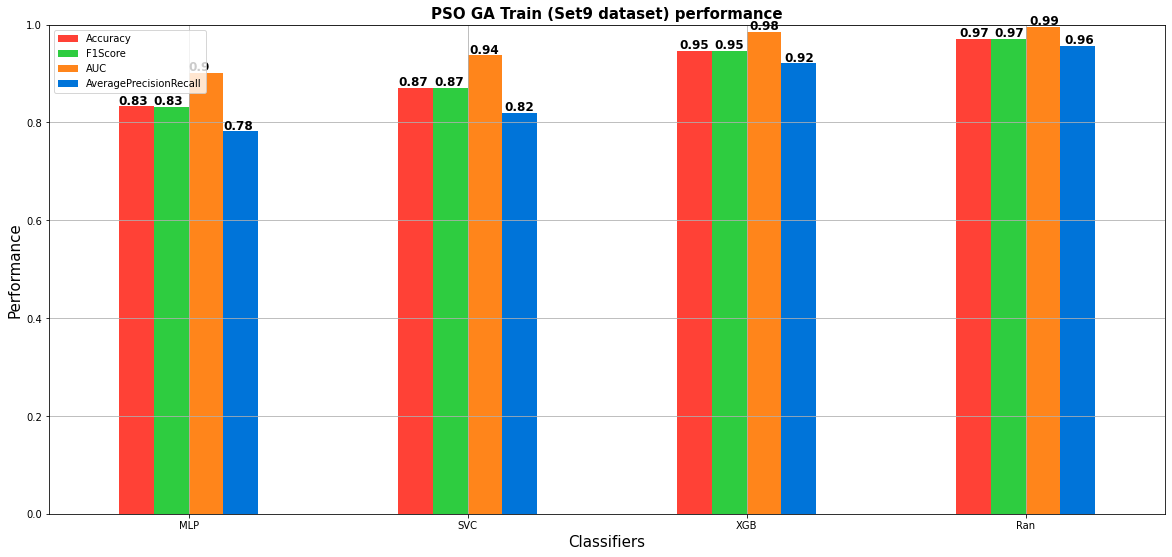


PSO GA Test set result:
              Accuracy   F1Score       AUC  AveragePrecisionRecall
Classifiers                                                      
MLP          0.764869  0.764847  0.828341                0.733300
SVC          0.781466  0.781446  0.849860                0.746548
XGB          0.785615  0.785614  0.863068                0.753803
Ran          0.785615  0.785483  0.875313                0.759237


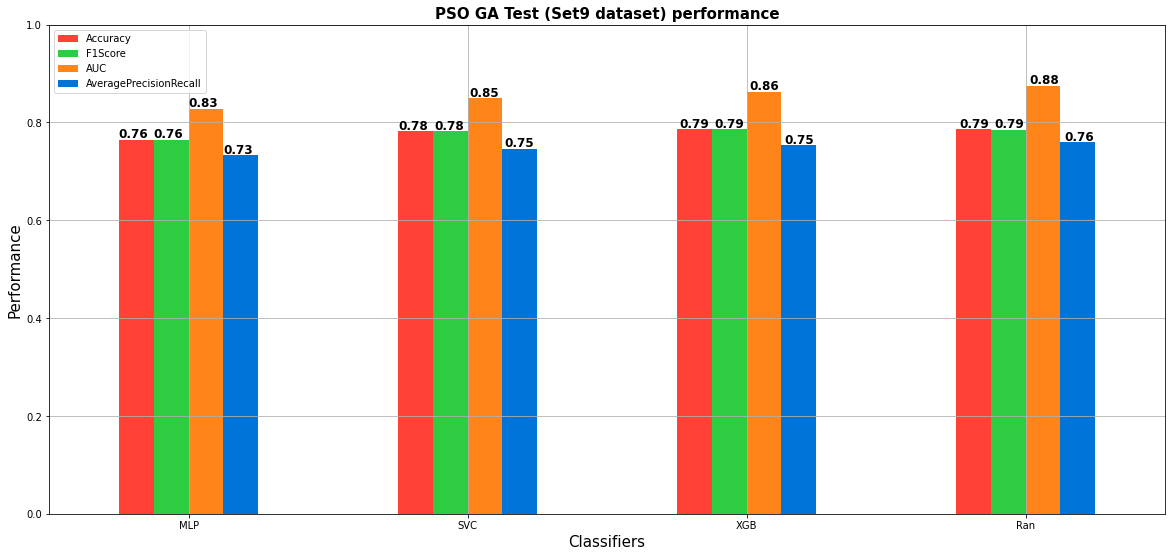

In [ ]:
# Results performance bar plot

color = ('#FF4136', '#2ECC40', '#FF851B', '#0074D9')
#FF851B orange, #FF4136 red, #0074D9, blue, #2ECC40 green)

# Function plotting the results performance
def plot_result(result_table, result_set):
  result_table = result_table.set_index('Classifiers')
  print(program_name, result_set, 'set result:\n', result_table)
  #ax = result_table.loc[:,['Accuracy','F1Score', 'AUC', 'AveragePrecisionRecall']].plot.bar(color=color, figsize=(20, 9))
  ax = result_table.plot.bar(color=color, figsize=(20, 9))
  plt.xticks(rotation=0)
  plt.ylabel("Performance", fontsize=15)
  plt.xlabel("Classifiers", fontsize=15)
  plt.ylim(0, 1.03)
  plt.grid(True)
  plt.legend(loc=2)
  plt.title('{} {} ({} dataset) performance'.format(program_name, result_set, dataset_set), fontweight='bold', fontsize=15)
  
  i = 0
  label = np.round(result_table.Accuracy.values, 2)
  for p in ax.patches:
      ax.annotate(str(round(p.get_height(),2 )), (p.get_x() * 1.005, p.get_height() * 1.005), fontweight='bold', fontsize=12)
      i = i+1

  plt.show()            
  print("")

plot_result(result_table_train_f1, "Train")
plot_result(result_table_test_f1, "Test")

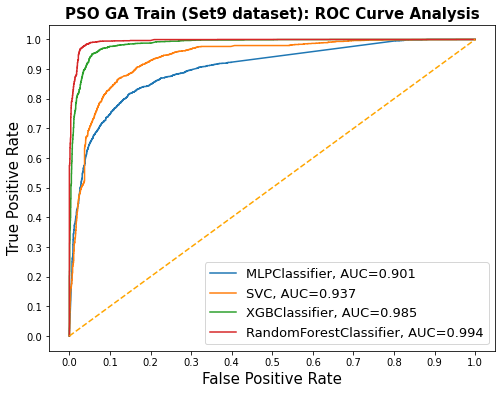

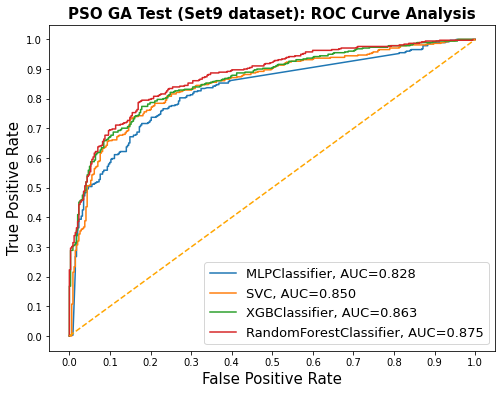

In [ ]:
# Plotting ROC/AUC

# Function plotting AUC
def plot_roc(result_table, result_set):
  fig1 = plt.figure(1, figsize=(8,6))
  for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
  plt.plot([0,1], [0,1], color='orange', linestyle='--')
  plt.xticks(np.arange(0.0, 1.1, step=0.1))
  plt.xlabel("False Positive Rate", fontsize=15)
  plt.yticks(np.arange(0.0, 1.1, step=0.1))
  plt.ylabel("True Positive Rate", fontsize=15)
  plt.title('{} {} ({} dataset): ROC Curve Analysis'.format(program_name, result_set, dataset_set), fontweight='bold', fontsize=15)
  plt.legend(prop={'size':13}, loc='lower right')

  plt.show()
  #fig.savefig('multiple_roc_curve.png')

plot_roc(result_table_train, "Train")
plot_roc(result_table_test, "Test")

In [ ]:
print('TOTAL elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - first_start_time))
print(mytime)
print("ALL DONE")

TOTAL elapsed (hh:mm:ss.ms) 1:26:06.065538
2020-03-19 15:33:33.559972+08:00
ALL DONE
